# New Climate Features

## Imports

In [1]:
import xarray as xr
import pandas as pd
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [4]:
from IndexDrivers import (
    AnomaliesIndex,
    MaxIndex, 
    calculate_anomalies
)
from PredictorsDrivers import (
    Predictor
)

## Code

### Preprocess Extra Indices

Let's preprocess the extra indices for ML. We use here DMI (Dipole Mode Index), ONI (Oceanic Niño Index), PDO (Pacific Decadal Oscillation), ENSO3.4 and 1+2 and SAM.

In [5]:
df_oni = pd.read_csv("data/extra_indices/oni.txt",sep="   |  | ", header=None, engine="python", names=["Season", "Year", "sst", "ONI"])
df_pdo = pd.read_csv("data/extra_indices/pdo.dat",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_sam = pd.read_csv("data/extra_indices/sam.txt",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
# df_meiv2 = pd.read_csv("data/extra_indices/meiv2.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso34 = pd.read_csv("data/extra_indices/nino34.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso12 = pd.read_csv("data/extra_indices/nino12.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_dmi = pd.read_csv("data/extra_indices/dmi.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])

In [6]:
def preprocess_df(df, name):
    df = df.melt(id_vars=['Year'], var_name='Month', value_name=name)
    df["Month"] = pd.to_numeric(df["Month"])
    df = df.sort_values(['Year','Month'])

    df['Date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
    df.set_index("Date", inplace=True)
    df.drop(columns=["Year", "Month"],inplace=True)
    return df

In [7]:
df_oni = pd.read_csv("data/extra_indices/oni.txt",sep="   |  | ", header=None, engine="python", names=["Season", "Year", "sst", "ONI"])
df_pdo = pd.read_csv("data/extra_indices/pdo.dat",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_sam = pd.read_csv("data/extra_indices/sam.txt",sep="  | ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
# df_meiv2 = pd.read_csv("data/extra_indices/meiv2.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso34 = pd.read_csv("data/extra_indices/nino34.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_enso12 = pd.read_csv("data/extra_indices/nino12.anom.data",sep="     |    |   ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])
df_dmi = pd.read_csv("data/extra_indices/dmi.data",sep="     |    ", header=None, engine="python", names=["Year"]+[str(i) for i in range(1,13)])

season_to_month = {
    "DJF": "02", "JFM": "03", "FMA": "04", "MAM": "05",
    "AMJ": "06", "MJJ": "07", "JJA": "08", "JAS": "09",
    "ASO": "10", "SON": "11", "OND": "12", "NDJ": "01"
}
df_oni["Year"] = df_oni.apply(lambda row: row["Year"] + 1 if row["Season"] == "NDJ" else row["Year"], axis=1)
df_oni["month"] = df_oni["Season"].map(season_to_month)
df_oni["Date"] = pd.to_datetime(df_oni["Year"].astype(str) + "-" + df_oni["month"])

# Select required columns
df_oni = df_oni[["Date", "ONI"]]
df_oni.set_index("Date", inplace=True)

df_pdo = preprocess_df(df_pdo, "PDO")
df_sam = preprocess_df(df_sam, "SAM")
# df_meiv2 = preprocess_df(df_meiv2, "MEI")
df_enso34 = preprocess_df(df_enso34, "ENSO34")
df_enso12 = preprocess_df(df_enso12, "ENSO12")
df_dmi = preprocess_df(df_dmi, "DMI")

In [8]:
df_pdo = df_pdo[(df_pdo.index.year >= 1972) & (df_pdo.index.year <=2022)]
df_oni = df_oni[(df_oni.index.year >= 1972) & (df_oni.index.year <=2022)]
df_sam = df_sam[(df_sam.index.year >= 1972) & (df_sam.index.year <=2022)]
# df_meiv2 = df_meiv2[(df_meiv2.index.year >= 1972) & (df_meiv2.index.year <=2022)]
df_enso34 = df_enso34[(df_enso34.index.year >= 1972) & (df_enso34.index.year <=2022)]
df_enso12 = df_enso12[(df_enso12.index.year >= 1972) & (df_enso12.index.year <=2022)]
df_dmi = df_dmi[(df_dmi.index.year >= 1972) & (df_dmi.index.year <=2022)]



### Definition of Predictors

In [5]:
data_single = xr.load_dataset("data/local_data/7means_east_pacific.nc")
data_850 = xr.load_dataset("data/local_data/3means_850hpa_east_pacific.nc")
data_mslp = xr.load_dataset("data/local_data/MSLP_east_pacific.nc")
ref_period = [1980,2010]

### Advection

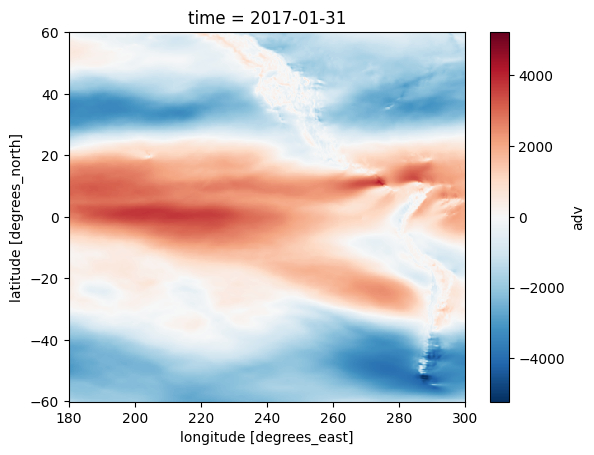

In [9]:
data_850["adv"] = -1*data_850.u*data_850.t
data_850.adv.sel(time="2017-01").plot()

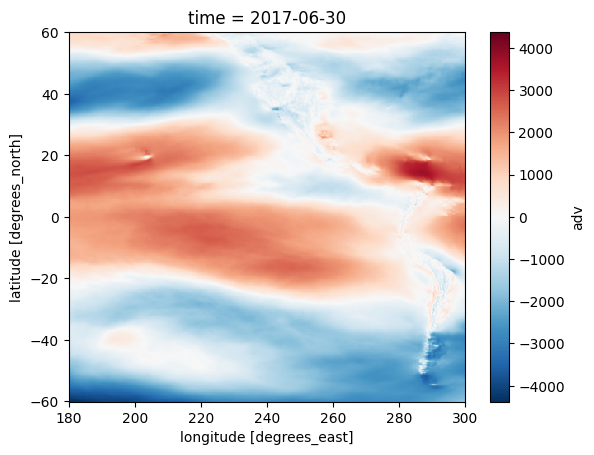

In [7]:
data_850.adv.sel(time="2017-06").plot()

### Pacific Predictors

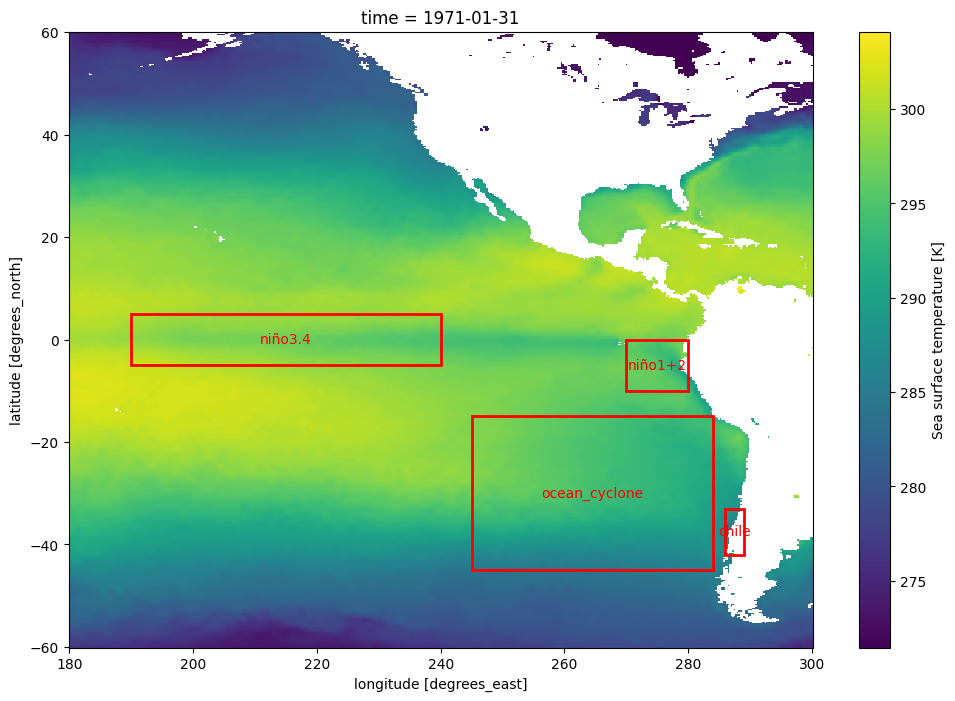

In [12]:
boxes_pacific = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "ocean_cyclone": [245, 284, -45, -15],
    "chile" : [286, 289, -42, -33]
    #"advección": [280, 285, -37, -30]
}

fig, ax = plt.subplots(figsize=(12, 8))

data_single.sst.isel(time=0).plot(ax=ax)

for box_id, coords in boxes_pacific.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [13]:
nino34 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño3.4"], rolling_window=1, frequency="monthly")
nino12 = AnomaliesIndex(data_single, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes_pacific["niño1+2"], rolling_window=1, frequency="monthly")
chile_t = AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["T"], box_limit=boxes_pacific["chile"], rolling_window=1, frequency="monthly")
ocean_cyclone = MaxIndex(data_mslp, [1972,2022], variables=["MSL"], box_limit=boxes_pacific["ocean_cyclone"], anomalies=True, climatology_period=ref_period)


In [14]:
ids_pacific = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in [nino34, nino12, ocean_cyclone]]

Saved
Saved
Saved


In [15]:
pacific_indices = [nino34, nino12, chile_t, ocean_cyclone]

### Chile Wind Predictors

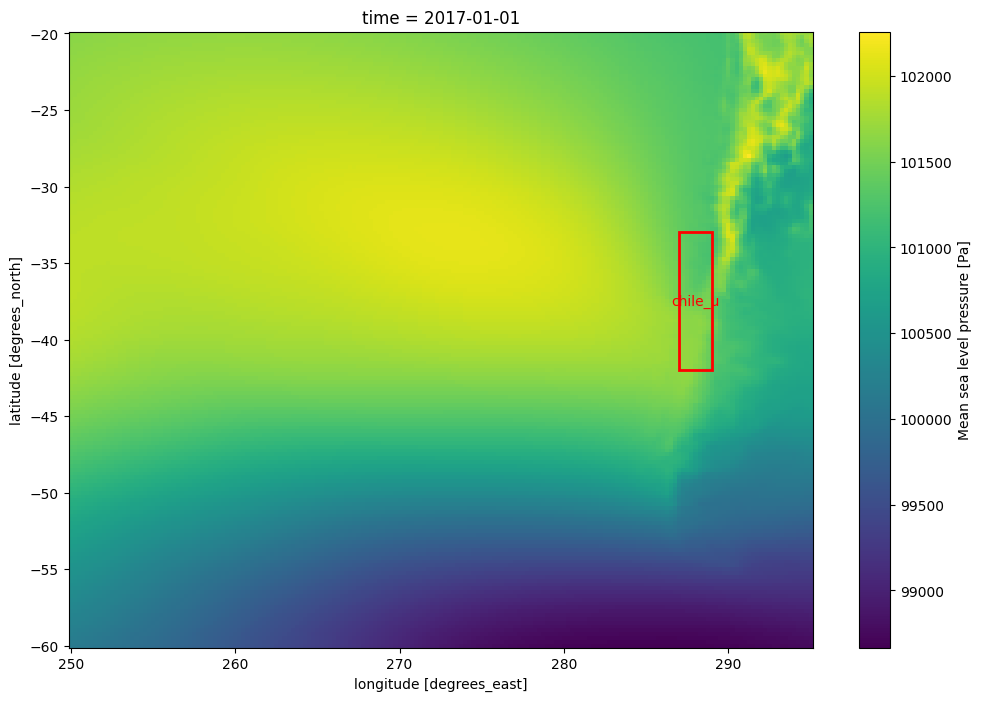

In [19]:
boxes_chile_winds = {
    "chile_u": [287, 289, -42, -33],
}

fig, ax = plt.subplots(figsize=(12, 8))

data_mslp.sel(longitude=slice(250,295), latitude=slice(-60,-20), time="2017-01").msl.plot(ax=ax)

for box_id, coords in boxes_chile_winds.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

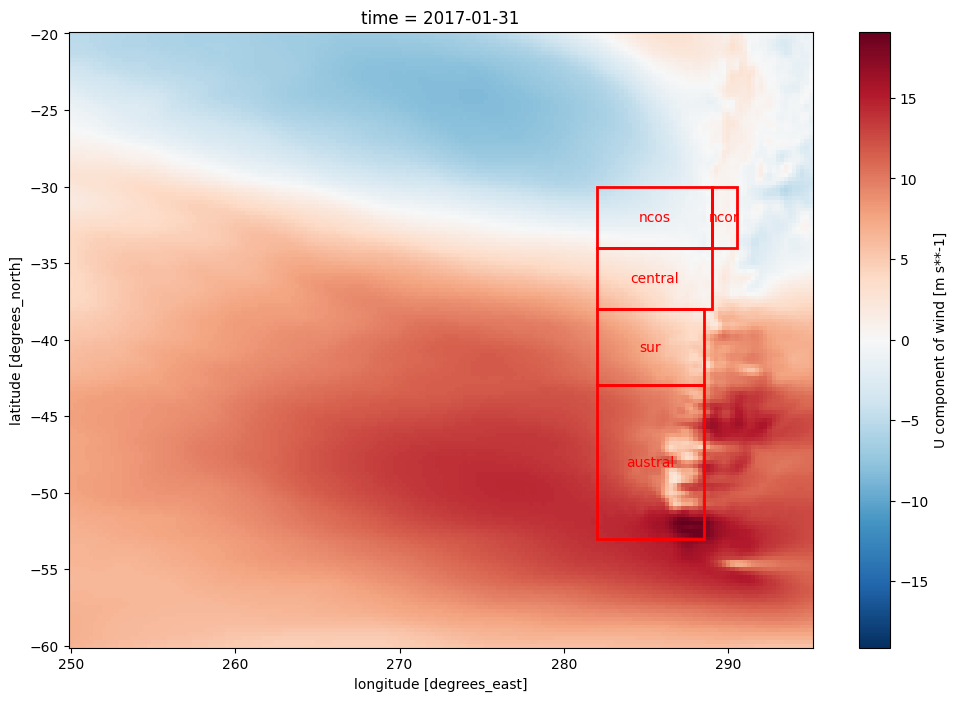

In [16]:
boxes_chile_winds = {
    "ncos": [282, 289, -34, -30],
    "ncor": [289, 290.5, -34, -30],
    "central": [282, 289, -38,-34],
    "sur": [282,288.5, -43, -38],
    "austral": [282,288.5, -53, -43],
}

fig, ax = plt.subplots(figsize=(12, 8))

data_850.sel(longitude=slice(250,295), latitude=slice(-60,-20), time="2017-01").u.plot(ax=ax)

for box_id, coords in boxes_chile_winds.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [17]:
wind_indices = [AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["U"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_winds.items()]

In [18]:
ids_winds = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in wind_indices]

Saved
Saved
Saved
Saved
Saved


### Chile Pressure Anomalies Indices

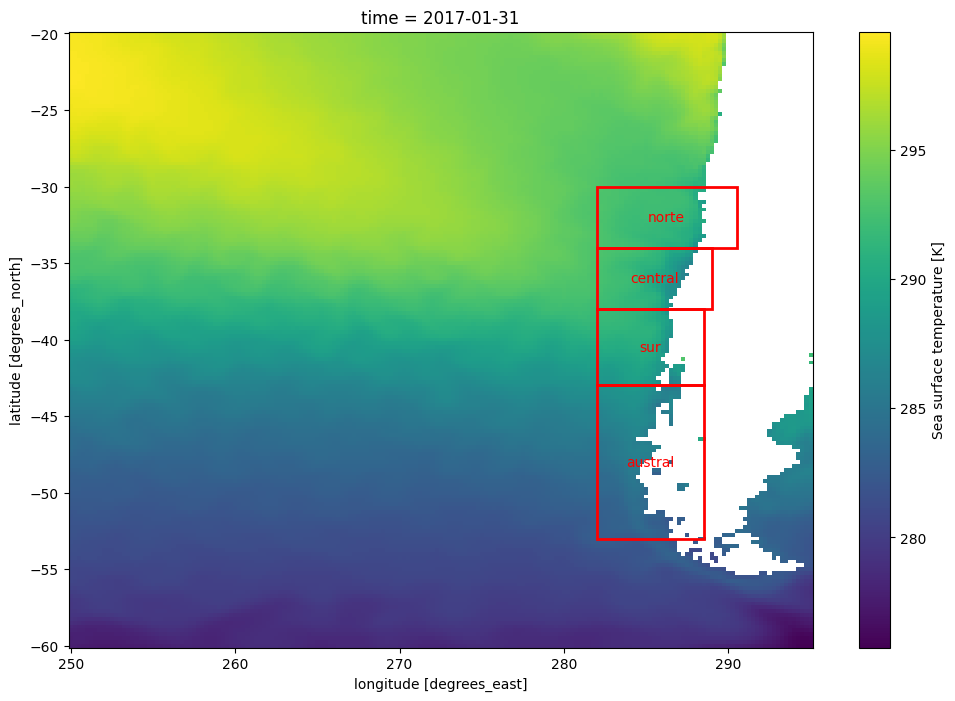

In [20]:
boxes_chile_mslp = {
    "norte": [282, 290.5, -34, -30],
    "central": [282, 289, -38,-34],
    "sur": [282,288.5, -43, -38],
    "austral": [282,288.5, -53, -43],
}

fig, ax = plt.subplots(figsize=(12, 8))

data_single.sel(longitude=slice(250,295), latitude=slice(-60,-20), time="2017-01").sst.plot(ax=ax)

for box_id, coords in boxes_chile_mslp.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [20]:
mslp_indices = [AnomaliesIndex(data_mslp, [1972,2022], reference_period=ref_period, variables=["MSL"], box_limit=box, rolling_window=1, frequency="monthly") for key,box in boxes_chile_mslp.items()]

In [21]:
ids_mslp = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in mslp_indices]

Saved
Saved
Saved
Saved


### Chile Max Pressures (altas migratorias)

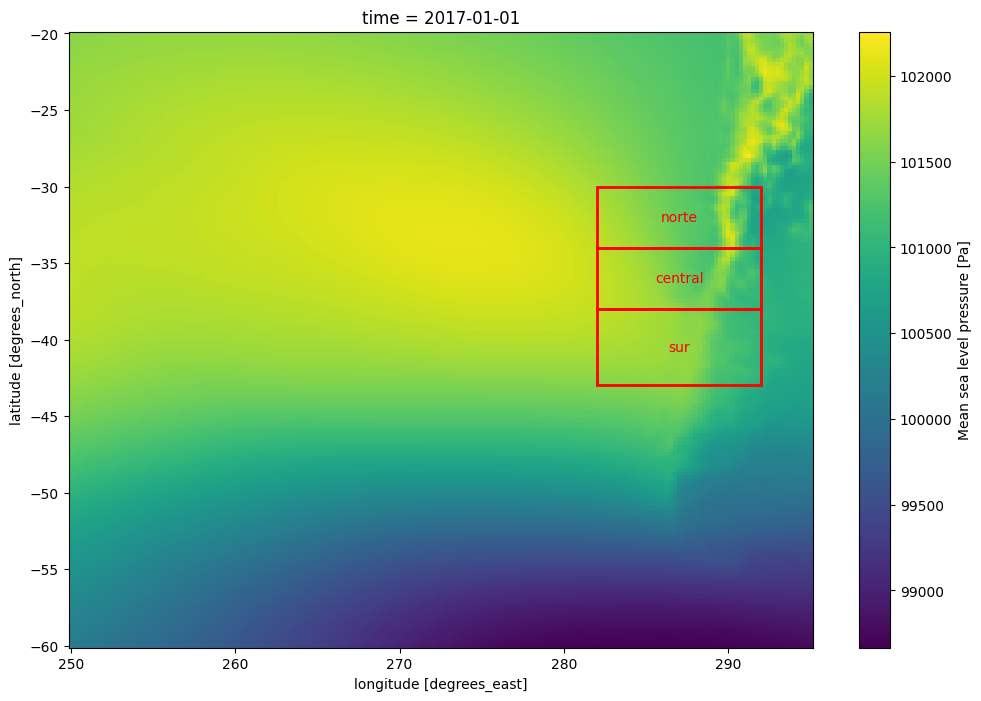

In [22]:
boxes_chile_altas = {
    "norte": [282, 292, -34, -30],
    "central": [282, 292, -38,-34],
    "sur": [282,292, -43, -38],
}

fig, ax = plt.subplots(figsize=(12, 8))

data_mslp.sel(longitude=slice(250,295), latitude=slice(-60,-20), time="2017-01").msl.plot(ax=ax)

for box_id, coords in boxes_chile_altas.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [23]:
altas_indices = [MaxIndex(data_mslp, [1972,2022], variables=["MSL"], box_limit=box, anomalies=True, climatology_period=ref_period) for key,box in boxes_chile_altas.items()]

In [24]:
ids_altas = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in altas_indices]

Saved
Saved
Saved


### Chile Advection

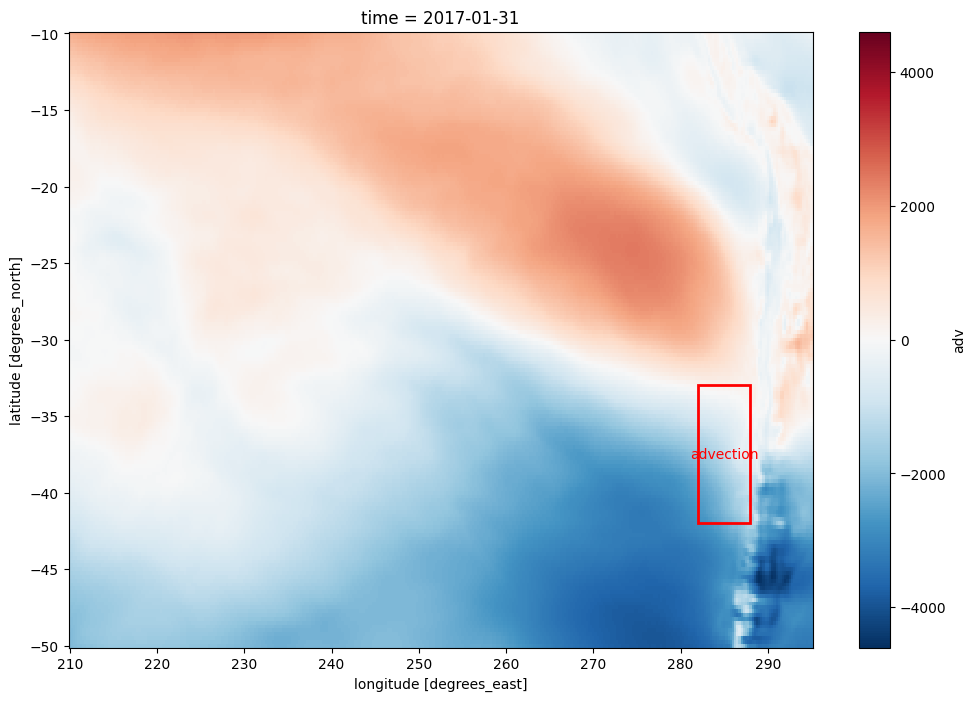

In [13]:
boxes_chile_adv = {
    "advection": [282, 288, -42, -33],
}

fig, ax = plt.subplots(figsize=(12, 8))

data_850.sel(longitude=slice(210,295), latitude=slice(-50,-10), time="2017-01").adv.plot(ax=ax)

for box_id, coords in boxes_chile_adv.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

<Axes: xlabel='time'>

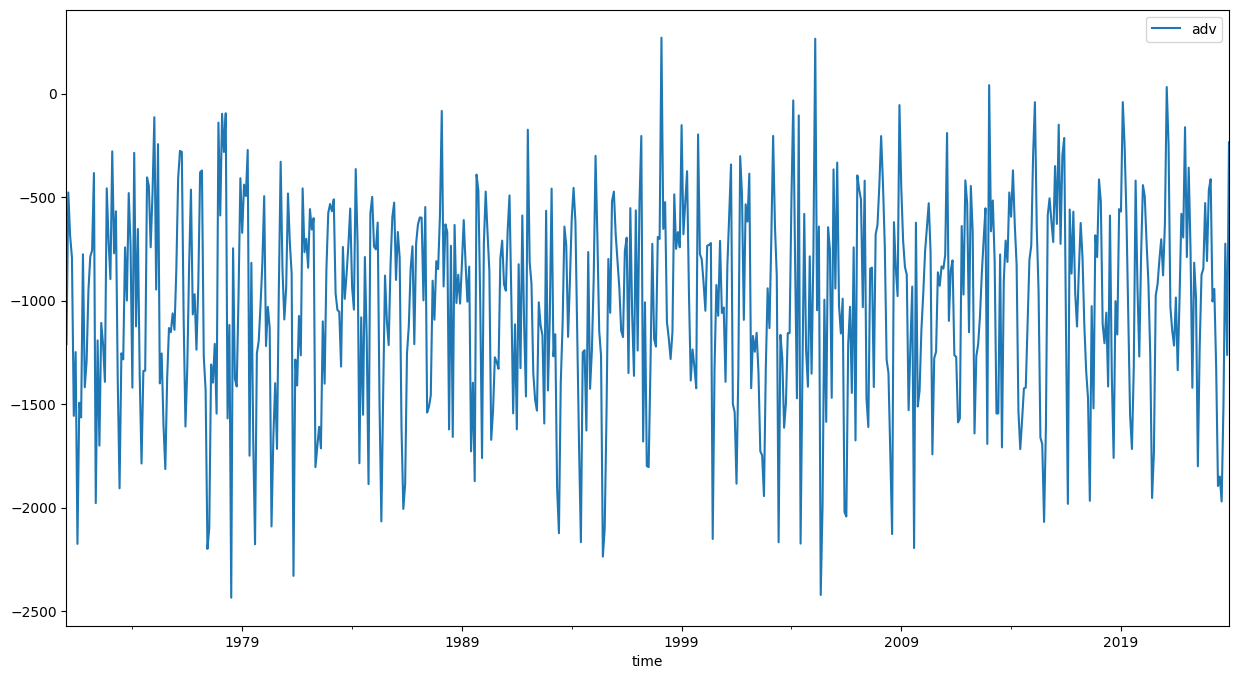

In [14]:
advection_df = data_850.sel(
    longitude=slice(boxes_chile_adv["advection"][0],boxes_chile_adv["advection"][1]),
    latitude=slice(boxes_chile_adv["advection"][2], boxes_chile_adv["advection"][3])).adv.mean(dim=["longitude","latitude"]).to_dataframe()
fig, ax = plt.subplots(1, figsize=(15,8))
advection_df.plot(ax=ax)

<Axes: xlabel='Date'>

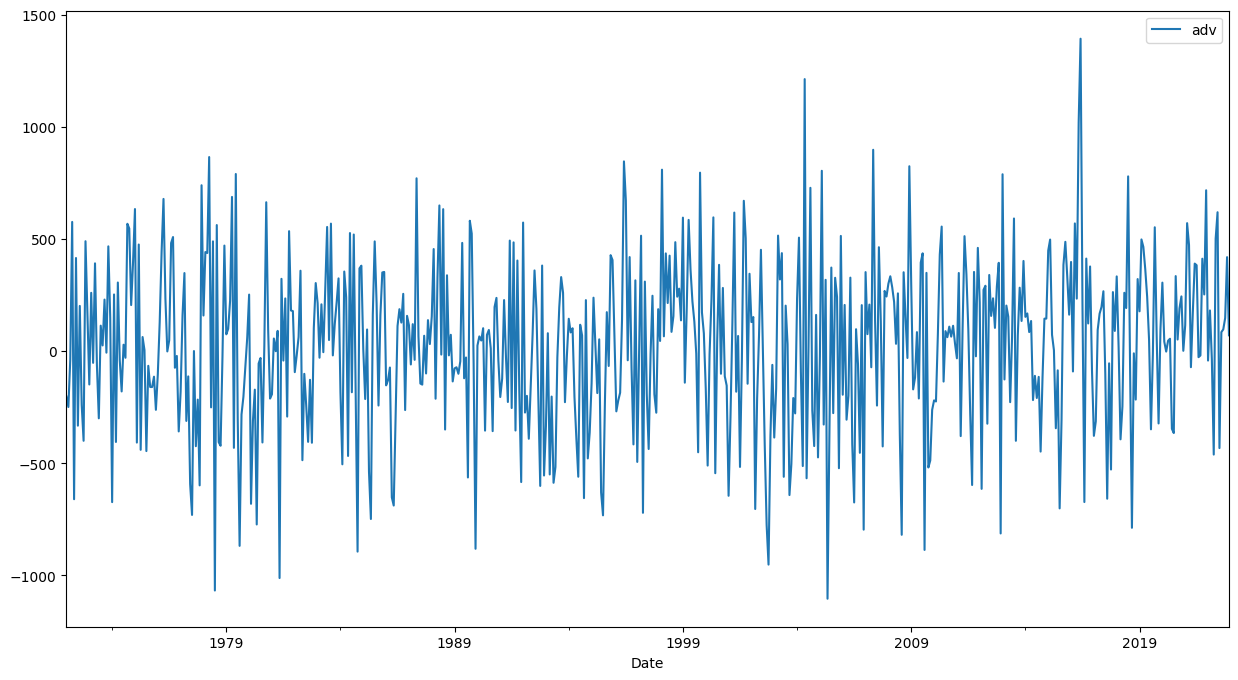

In [15]:
anom_advection = AnomaliesIndex(data_850, [1972,2022], reference_period=ref_period, variables=["ADV"], box_limit=boxes_chile_adv["advection"], rolling_window=1)
fig, ax = plt.subplots(1, figsize=(15,8))
anom_advection.get_index_by_variable("ADV").plot(ax=ax)

In [28]:
ids_adv = [anom_advection.index_df_to_parquet(anom_advection.variables[0], "data/my_indices/","data/my_indices/metadata.csv")]

Saved


In [29]:
advection_df = advection_df[(advection_df.index.year>= 1972) & (advection_df.index.year<= 2022)]
advection_df.index = advection_df.index.to_numpy().astype('datetime64[M]') ## Set the index as first day of the month
advection_df.index.name="Date"
advection_df

,adv
Date,
1972-01-01,-1317.188965
1972-02-01,-1457.873901
1972-03-01,-1066.537231
1972-04-01,-1592.476196
1972-05-01,553.169556
...,...
2022-08-01,-897.598267
2022-09-01,-1000.809326
2022-10-01,-1222.156128


## Create Experiments

In [30]:
predictors = Predictor()
extra_indices_names = ["PDO", "ONI", "SAM", "DMI", "ADV"]
# extra_indices_names = ["PDO", "SAM", "DMI", "ADV"]
extra_indices = [df_pdo, df_oni, df_sam, df_dmi, advection_df]


In [31]:
my_indices_ids = ids_pacific + ids_winds + ids_mslp + ids_altas
Indices = pacific_indices + wind_indices + mslp_indices + altas_indices
my_indices = [index.get_index_by_variable(index.variables[0]) for index in Indices]

In [32]:
#exp, num = predictors.incorporate_predictor(my_indices, my_indices_ids)
exp, num = predictors.incorporate_predictor(my_indices+extra_indices, my_indices_ids+extra_indices_names)

## Chile

In [33]:
hwis_chile= pd.read_csv(f"data/local_data/monthly/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y-%m')
hwis_chile.set_index('Date', inplace=True)
region="chile"

In [34]:
exp_label, num_label = predictors.incorporate_label(hwis_chile, num_exp=num)

In [35]:
predictors.experiment_to_parquet(num_label, f"data/climate_features/{region}/", f"data/climate_features/{region}/metadata.csv")

Saved


## California

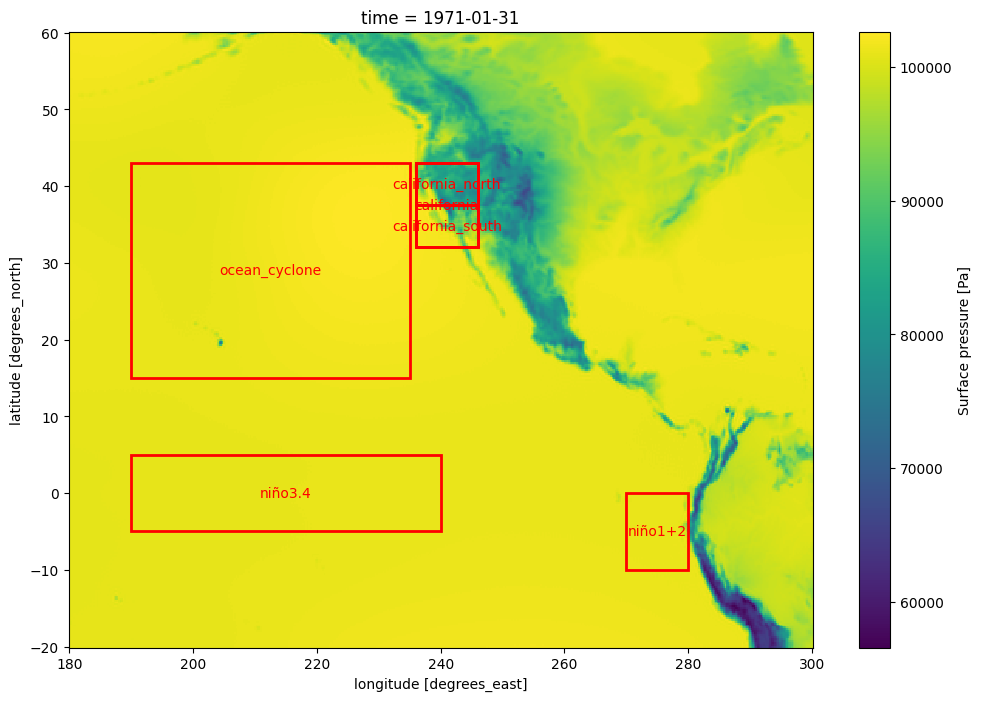

In [37]:
data = xr.load_dataset("data/local_data/7means_east_pacific.nc")

boxes = {
    "niño3.4": [190, 240, -5, 5],  # [lon_min, lon_max, lat_min, lat_max]
    "niño1+2": [270, 280, -10, 0],
    "california_north": [236, 246, 37.5, 43],
    "california_south": [236, 246, 32, 37.5],
    "california": [236,246, 32, 43],
    "ocean_cyclone": [190, 235, 15, 43],
}

fig, ax = plt.subplots(figsize=(12, 8))

data.sel(latitude=slice(-20, 60), longitude=slice(130, 300)).sp.isel(time=0).plot(ax=ax)

for box_id, coords in boxes.items():
    lon_min, lon_max, lat_min, lat_max = coords
    width = lon_max - lon_min
    height = lat_max - lat_min
    
    # Create rectangle patch
    rect = mpatches.Rectangle((lon_min, lat_min), width, height,
                             fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    
    # Optionally add a label
    ax.text(lon_min + width/2, lat_min + height/2, f"{box_id}", 
            ha='center', va='center', color='red')

plt.show()

In [31]:
data = xr.load_dataset("data/local_data/7means_world.nc")

In [32]:
ref_period = [1980,2010]

In [33]:
nino34 = AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes["niño3.4"], rolling_window=1, frequency="monthly")
nino12 = AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SST"], box_limit=boxes["niño1+2"], rolling_window=1, frequency="monthly")
Indices = [nino34, nino12, 
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SP"], box_limit=boxes["california_north"], rolling_window=1, frequency="monthly"), 
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["SP"], box_limit=boxes["california_south"], rolling_window=1, frequency="monthly"),
           MaxIndex(data, [1972,2022], variables=["SP"], box_limit=boxes["ocean_cyclone"]),
           AnomaliesIndex(data, [1972,2022], reference_period=ref_period, variables=["U10"], box_limit=boxes["california"], rolling_window=1, frequency="monthly")]


In [34]:
ids = [index.index_df_to_parquet(index.variables[0], "data/my_indices/","data/my_indices/metadata.csv") for index in Indices]

Saved
Saved
Saved
Saved
Saved
Saved


In [37]:
predictors = Predictor()
extra_indices_names = ["PDO", "ONI", "SAM", "DMI"]
extra_indices = [df_pdo, df_oni, df_sam, df_dmi]

my_indices_ids = ids
my_indices = [index.get_index_by_variable(index.variables[0]) for index in Indices]
exp, num = predictors.incorporate_predictor(my_indices+extra_indices, my_indices_ids+extra_indices_names)

In [38]:
hwis_cali= pd.read_csv(f"data/local_data/monthly/HWs_california_NOAA.csv")
hwis_cali["Date"] = pd.to_datetime(hwis_cali["Date"],format='%Y-%m')
hwis_cali.set_index('Date', inplace=True)
region="california"

In [39]:
exp_label2, num_label2 = predictors.incorporate_label(hwis_cali, num_exp=num)

In [45]:
predictors.experiment_to_parquet(num_label2, f"data/climate_features/{region}/", f"data/climate_features/{region}/metadata.csv")

Saved
